In [1]:
import json
import csv
import subprocess
import os
import rasterio
import shutil
import glob

import pandas as pd
import geopandas as geopd
from rasterio.mask import mask
from rasterio.transform import from_gcps
from rasterio.control import GroundControlPoint
from shapely.geometry import Polygon
from difflib import get_close_matches
from IPython.display import display

In [2]:
def fix_name(unchecked_name, true_names):
    """ Ä:s and ö:s are missing and instead they have been swapped
    with a space and the next character is capitalized. This finds the best matching actual name.
    Returns a tuple where first entry is the fixed name and the second entry is a indicator on
    whether the new name is a good (0) or bad (1) match
    """
    """ adding some Ä:s. This solves some problems. 
    """
    is_bad_name = 0
    
    if len(get_close_matches(unchecked_name, true_names, cutoff=1.0)) == 1:
        name = unchecked_name
        return name, is_bad_name
    
    if len(unchecked_name.split()) > 1:
        name_parts = unchecked_name.split()
        unchecked_name = name_parts[0]
        for name_part in name_parts[1:]:
            unchecked_name += 'ä' + name_part
        unchecked_name = unchecked_name.title()
        
    # using try error to get a list of badly matching names    
    try:
        name = get_close_matches(unchecked_name, true_names, n=1,)
        name = name[0]
        is_bad_name = 1
    except IndexError:
        name = get_close_matches(unchecked_name, true_names, n=1, cutoff=0.0)
        name = name[0]
        is_bad_name = 2
    return name, is_bad_name

def is_hole_in_sheets(years, sheet_ids, sheet_id):
    hole_flag = True
    if sheet_id in sheet_ids:
        index_occurences = []

        # not using index() because we want to also compare the years, meaning that we need all occurences
        for i, compared_id in enumerate(sheet_ids):
            if compared_id == sheet_id:
                index_occurences.append(i)
        for index in index_occurences:
            if years[index] < year + 5 and years[index] > year -5:
                hole_flag = False
        return hole_flag
            
    else:
        return hole_flag
        
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

Found hole for sheet 371401 and year 1963, filling it with found non-cadastral map
Found hole for sheet 371404 and year 1962, filling it with found non-cadastral map
Found hole for sheet 371407 and year 1964, filling it with found non-cadastral map
Found hole for sheet 371303 and year 1962, filling it with found non-cadastral map
Found hole for sheet 371306 and year 1962, filling it with found non-cadastral map
Found hole for sheet 362302 and year 1954, filling it with found non-cadastral map
Found hole for sheet 362302 and year 1969, filling it with found non-cadastral map
Found hole for sheet 362305 and year 1954, filling it with found non-cadastral map
Found hole for sheet 362305 and year 1969, filling it with found non-cadastral map
Found hole for sheet 362308 and year 1952, filling it with found non-cadastral map
Found hole for sheet 362308 and year 1969, filling it with found non-cadastral map
Found hole for sheet 362311 and year 1952, filling it with found non-cadastral map
Foun

<Axes: >

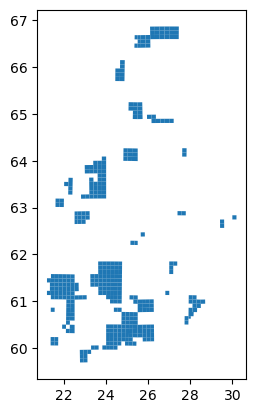

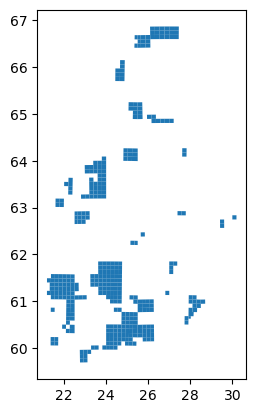

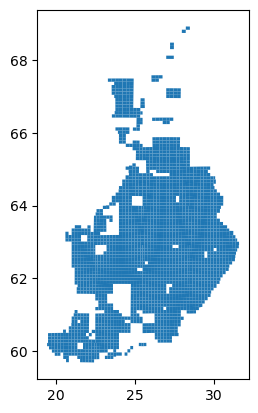

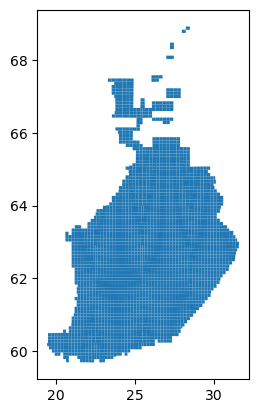

In [4]:
# Path to file containing all the actual names of map sheets. the json has some problems with ä:s and ö:s
name_path = "vanhojen karttojen metadata/nimet.csv"

with open(name_path) as opened_csv:
    true_names_pre = list(csv.reader(opened_csv, delimiter=";"))

true_names = []
# Each name is contained in a separate list, this fixes that
for i in range(len(true_names_pre)):
    true_names.append(true_names_pre[i][0])
    
# Converting to dict and back to list to remove duplicates
true_names  = list(dict.fromkeys(true_names))

# Changing to smallcase
true_names = [true_name.title() for true_name in true_names]

# Changing underscores to spaces
true_names = [true_name.replace("_", " ") for true_name in true_names]

json_path = "data/meta_karttalehti/historic-maps-export_no_triples.json"


with open(json_path) as json_file:
    data = json.load(json_file)

name_fixes = {"Lyly": "Öllölä", "Skaftung": "Saggö", "Pinola": "Finbo",
              "Puuppola": "Äpplö", "Bergö": "Eckerö", "Äljy":"Äljy",
              "Barösund":"Grundsunda", "Nölstö": "Föglö","Farten":"Oxbrotten",
              "Ruto": "Örö"}

years = []
urls = []
names = []
sheet_ids = []
coordinates = []
name_not_ok = []
filenames = []
updated = []
for sheet in data:
    year = sheet['year']
    url = sheet['original_url']
    filename = os.path.basename(url)
    sheet_id = filename[:6]
    name = sheet['title']
    coordinate = sheet['gcps']
    update = False
    
    # Filtering only base maps
    if "Peruskartta" not in url:
        continue
    # taking only maps older than 1978
    if year > 1978:
        continue
    # There are two versions of the maps, this retains only the ones with cadastral borders unless it is missing
    if "ei_rajoja" in url:
        if is_hole_in_sheets(years, sheet_ids, sheet_id):
            print(f"Found hole for sheet {sheet_id} and year {year}, filling it with found non-cadastral map")
        else:
            continue
    # There are sometimes versions with other projections, they can be skipped
    if "ykj" in filename or "kkj" in filename:
        if is_hole_in_sheets(years, sheet_ids, sheet_id):
            print(f"Found hole for sheet {sheet_id} and year {year}, filling it with found ykj or_kkj suffix map")
        else:
            print(f"skipped {filename} because similar with different projection already exists")
            continue
    # Fixing names
    fixed_name, is_bad_name = fix_name(name, true_names)
    if is_bad_name == 2:
        print(f"sheet id: {sheet_id} original name:{name} fixed_name: {fixed_name}")
        fixed_name = name_fixes[fixed_name]
    # Hyrkkölä has a wrong id that needs to be fixed
    if fixed_name == "Hyrkkölä":
            sheet_id = 202410
            filename = "202410_1960.jpg"
    # Hastersboda changes to raaterova in the code, this is a fix
    if fixed_name == "Raaterova" and sheet_id == 101104:
        fixed_name == "Hastersboda"

    if filename == "433202_1976.jpg":
        filename = "433202_1976.JPG"
    if filename == "311204_1965.jpg":
        filename = "311204__1965.jpg"

    if sheet_id in sheet_ids:
        update = True
    years.append(year)
    urls.append(url)
    names.append(fixed_name)
    sheet_ids.append(sheet_id)
    coordinates.append(coordinate)
    name_not_ok.append(is_bad_name)
    filenames.append(filename)
    updated.append(update)
#Creates a geopackage from the coordinates
geometry = []
for i in range(len(years)):
    boundaries = coordinates[i]
    lons = []
    lats = []
    for corner in boundaries:
        lons.append(corner[2])
        lats.append(corner[3])
    
    square = Polygon(zip(lons, lats))
    geometry.append(square)


columns = {'year': years, 'url': urls, 'filename': filenames, 'sheet_id':sheet_ids,'name':names,  "name_not_ok": name_not_ok, "updated":updated, "geometry":geometry}
sheet_grid = geopd.GeoDataFrame(data=columns, crs="EPSG:4326")
sheet_grid['duplicated'] = sheet_grid.duplicated(subset='sheet_id', keep=False)
sheet_grid_new_updated = sheet_grid.loc[sheet_grid['updated'] & sheet_grid['duplicated']]
sheet_grid_old_updated = sheet_grid.loc[((~sheet_grid['updated']) & (sheet_grid['duplicated']))]
sheet_grid_not_updated = sheet_grid.loc[((~sheet_grid['updated']) & (~sheet_grid['duplicated']))]
sheet_grid_newer = pd.concat([sheet_grid_new_updated, sheet_grid_not_updated])

sheet_grid.to_file("data/grids/map_sheets2.gpkg", driver="GPKG")
sheet_grid_old_updated.to_file("data/grids/old_updated.gpkg", driver="GPKG")
sheet_grid_newer.to_file("data/grids/newer.gpkg", driver="GPKG")

sheet_grid.head()
sheet_grid_old_updated.plot()
sheet_grid_new_updated.plot()
sheet_grid_not_updated.plot()
sheet_grid_newer.plot()


- checking if the files are downloaded and loads them if necessary

In [14]:

dldir = "/home/iiro/Downloads"
dest_dir = "/home/iiro/Documents/Koulutyöt/Gradu/data/georef_kartat"
for url in urls:
    file_name = os.path.basename(url)
    file_path = os.path.join(dest_dir, file_name)
    if not os.path.exists(file_path):
        # required for Hyrkkölä, which has already been loaded
        if file_name == "201410_1960.jpg":
            pass
            """
            new_name = os.path.join(dldir, "202410_1960.jpg")
            os.rename(file_name, new_name)
            """
        print(file_name)
        
        #subprocess.call(['wget', "--no-verbose","-P", dldir, url])
        


201410_1960.jpg


In [5]:
# Georeferencing images
#orig_dir = "/home/iiro/980/GIS980/Gradu/alk_kartat"
dest_dir = "/home/iiro/Documents/Koulutyöt/Gradu/data/tmp"
for i, filename in enumerate(filenames):
    if not filename == "304406_304409_1974.jpg":
        continue
    
    dest_file = os.path.join(dest_dir, filename)
    gcps = []
    boundaries = coordinates[i]
    for corner in boundaries:
        gcps.append(GroundControlPoint(corner[1], corner[0], corner[2], corner[3]))
    if len(gcps) == 4:
        corrected_gcps = gcps[0], gcps[1], gcps[2], gcps[3]
    # Edges of projections have six corners
    if len(gcps) == 6:
        corrected_gcps = gcps[0], gcps[1], gcps[2], gcps[3], gcps[4], gcps[5]
    transform = from_gcps(corrected_gcps)
    crs = 'epsg:4326'
    
    try:
        with rasterio.open(dest_file, 'r+') as ds:
            ds.crs = crs
            ds.transform = transform
    except:
        print(f"File not found:{filename}, check working of URL{urls[i]}")

/home/iiro/anaconda3/envs/geo/lib/python3.11/site-packages/rasterio/__init__.py:306: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = get_writer_for_path(path, driver=driver)(


In [8]:
"""
url = "https://vanhatpainetutkartat.maanmittauslaitos.fi/mml_vanhat_kartat/Painetut_kartat/21_Peruskartta_20k/4/4332/433202/433202_1976_ei_rajoja.JPG"
dest_dir = "/home/iiro/980/GIS980/Gradu/georef_kartat"
i = 942
filename = os.path.basename(url)
#orig_file = os.path.join(orig_dir, filename)
dest_file = os.path.join(dest_dir, filename)
gcps = []
boundaries = coordinates[i]
for corner in boundaries:
    gcps.append(GroundControlPoint(corner[1], corner[0], corner[2], corner[3]))

print(gcps)
corrected_gcps = gcps[0], gcps[1], gcps[2], gcps[3]
transform = from_gcps(corrected_gcps)
crs = 'epsg:4326'

try:
    with rasterio.open(dest_file, 'r+') as ds:
        ds.crs = crs
        ds.transform = transform
except:
    print(f"File not found:{filename}, check working of URL{url}")
"""

[GroundControlPoint(row=508, col=342, x=29.996767776157, y=63.372238497608, id='c0706ff7-b689-4516-941c-20e4f720e0cc'), GroundControlPoint(row=516, col=6212, x=30.19666058712, y=63.372103433375, id='88563425-840b-46b5-b37f-786ee31baac3'), GroundControlPoint(row=6404, col=6205, x=30.196050093289, y=63.282391374947, id='8fd065ba-05c0-40ff-98d5-d8a3ecb9c238'), GroundControlPoint(row=6390, col=328, x=29.99677849609, y=63.282525908932, id='cee4d43e-7c95-4602-bd14-467cdbe3ac6c')]


In [ ]:
#Does not work, use qgis script instead
"""
clip_dir = "/home/iiro/Documents/Koulutyöt/Gradu/data/clip_kartat/newer_v2"
orig_dir = "/home/iiro/Documents/Koulutyöt/Gradu/data/georef_kartat"
problems = []
for i, filename in enumerate(sheet_grid_newer['filename']):
    problem_flag=False
    name = filename[:-4]
    name_orig_path = os.path.join(orig_dir, name + "*")
    clip_path = os.path.join(clip_dir, filename)
    # Copying the file and accompanying xml, which contains the projection and transformation information
    for file in glob.glob(name_orig_path):
        shutil.copy(file, clip_dir)
    bbox_df = sheet_grid.loc[[i]]
    bbox = getFeatures(bbox_df)
    with rasterio.open(clip_path) as src:
        try:
            out_image, out_transform = mask(src, bbox, crop=True)
            out_meta = src.meta.copy()
        except ValueError:
            print(f"problem with masking sheet {name}, bbox: {bbox}, raster extent: {src.bounds}")
            problems.append(filename)
            out_meta = None
            out_image = None
            problem_flag=True
        
    if problem_flag:
        continue
    out_meta.update({"driver": "JPEG",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
    with rasterio.open(clip_path, "w", **out_meta) as dest:
        dest.write(out_image)
"""

In [9]:
test_string = "test_ima.jpg"
print(test_string[:-4])

test_ima


In [8]:
for row in sheet_grid_newer['filename']:
    

384304_1967.jpg
383403_1965.jpg
383105_1972.jpg
383104_1972.jpg
374201_1966.jpg
374204_1966.jpg
371401_1963_ei_rajoja.jpg
371404_1962_ei_rajoja.jpg
371407_1964_ei_rajoja.jpg
271306_1977.jpg
271309_1977.jpg
271312_1977.jpg
273103_1977.jpg
273106_1977.jpg
273109_1977.jpg
273112_1977.jpg
371303_1962_ei_rajoja.jpg
371306_1962_ei_rajoja.jpg
273102_1977.jpg
273105_1977.jpg
273108_1977.jpg
273111_1977.jpg
271307_1977.jpg
271310_1977.jpg
273101_1977.jpg
273104_1977.jpg
273107_1977.jpg
273110_1977.jpg
262409_1977.jpg
262412_1977.jpg
264203_1977.jpg
264206_1977.jpg
264209_1977.jpg
264212_1977.jpg
364203_1968.jpg
364206_1968.jpg
364209_1968.jpg
364212_1968.jpg
262408_1977.jpg
262411_1977.jpg
264202_1977.jpg
264205_1977.jpg
264208_1977.jpg
264211_1977.jpg
364202_1968.jpg
364205_1968.jpg
364208_1968.jpg
364211_1968.jpg
264201_1977.jpg
264204_1977.jpg
264207_1977.jpg
264210_1977.jpg
364201_1968.jpg
364204_1968.jpg
364207_1968.jpg
364210_1968.jpg
262312_1977.jpg
264103_1977.jpg
264106_1977.jpg
264109